### Remote work impacts on health

#### Description 
The Post-Pandemic Remote Work Health Impact 2025 dataset presents a comprehensive, global snapshot of how remote, hybrid, and onsite work arrangements are influencing the mental and physical health of employees in the post-pandemic era. Collected in June 2025, this dataset aggregates responses from a diverse workforce spanning continents, industries, age groups, and job roles. It is designed to support research, data analysis, and policy-making around the evolving landscape of work and well-being.

This dataset enables in-depth exploration of:

The prevalence of mental health conditions (e.g., anxiety, burnout, PTSD, depression) across different work setups.
The relationship between work arrangements and physical health complaints (e.g., back pain, eye strain, neck pain).
Variations in work-life balance, social isolation, and burnout levels segmented by demographic and occupational factors.
Salary distributions and their correlation with health outcomes and job roles.
By providing granular, anonymized data on both subjective (self-reported) and objective (hours worked, salary range) factors, this resource empowers data scientists, health researchers, HR professionals, and business leaders to:

Identify risk factors and protective factors for employee well-being.
Benchmark health impacts across industries and regions.
Inform organizational policy and future-of-work strategies.

In [38]:
import pandas as pd
import numpy as np 
from kaggle.api.kaggle_api_extended import KaggleApi
import matplotlib.pyplot as plt

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import OrdinalEncoder

# dt imports 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from sklearn import tree


from imblearn.over_sampling import SMOTE

pd.set_option("display.max_columns", None)

api = KaggleApi()
api.authenticate()

api.dataset_download_files(
    'kshitijsaini121/remote-work-of-health-impact-survey-june-2025',
    path='data/',
    unzip=True 
)

df = pd.read_csv("data/post_pandemic_remote_work_health_impact_2025.csv", parse_dates=['Survey_Date'])

print(f"Shape of the Data: {df.shape}")


df.head()

Dataset URL: https://www.kaggle.com/datasets/kshitijsaini121/remote-work-of-health-impact-survey-june-2025
Shape of the Data: (3157, 14)


,Survey_Date,Age,Gender,Region,Industry,Job_Role,Work_Arrangement,Hours_Per_Week,Mental_Health_Status,Burnout_Level,Work_Life_Balance_Score,Physical_Health_Issues,Social_Isolation_Score,Salary_Range
0,2025-06-01,27,Female,Asia,Professional Services,Data Analyst,Onsite,64,Stress Disorder,High,3,Shoulder Pain; Neck Pain,2,$40K-60K
1,2025-06-01,37,Female,Asia,Professional Services,Data Analyst,Onsite,37,Stress Disorder,High,4,Back Pain,2,$80K-100K
2,2025-06-01,32,Female,Africa,Education,Business Analyst,Onsite,36,ADHD,High,3,Shoulder Pain; Eye Strain,2,$80K-100K
3,2025-06-01,40,Female,Europe,Education,Data Analyst,Onsite,63,ADHD,Medium,1,Shoulder Pain; Eye Strain,2,$60K-80K
4,2025-06-01,30,Male,South America,Manufacturing,DevOps Engineer,Hybrid,65,NaN,Medium,5,NaN,4,$60K-80K


## Data Cleaning 

Missing Values and Outlier Detection 

In [39]:
df.describe()

,Survey_Date,Age,Hours_Per_Week,Work_Life_Balance_Score,Social_Isolation_Score
count,3157,3157.000000,3157.000000,3157.000000,3157.000000
mean,2025-06-13 13:29:37.763699712,43.732024,49.904973,2.996516,2.704783
min,2025-06-01 00:00:00,22.000000,35.000000,1.000000,1.000000
25%,2025-06-07 00:00:00,33.000000,42.000000,2.000000,2.000000
50%,2025-06-14 00:00:00,44.000000,50.000000,3.000000,3.000000
75%,2025-06-20 00:00:00,55.000000,57.000000,4.000000,4.000000
max,2025-06-26 00:00:00,65.000000,65.000000,5.000000,5.000000
std,NaN,12.661095,8.897699,1.163307,1.188887


In [40]:
isna_cols = df.isna().sum()

print(isna_cols)

Survey_Date                  0
Age                          0
Gender                       0
Region                       0
Industry                     0
Job_Role                     0
Work_Arrangement             0
Hours_Per_Week               0
Mental_Health_Status       799
Burnout_Level                0
Work_Life_Balance_Score      0
Physical_Health_Issues     280
Social_Isolation_Score       0
Salary_Range                 0
dtype: int64


In [41]:
print(df['Mental_Health_Status'].value_counts())

Mental_Health_Status
PTSD               423
Anxiety            394
Burnout            392
Depression         386
ADHD               385
Stress Disorder    378
Name: count, dtype: int64


In [42]:
# Replace missing values in this column with 'None' because that was what was indicated in the documentation
df['Mental_Health_Status'] = df['Mental_Health_Status'].fillna('None')

In [43]:
print(df['Mental_Health_Status'].value_counts())

Mental_Health_Status
None               799
PTSD               423
Anxiety            394
Burnout            392
Depression         386
ADHD               385
Stress Disorder    378
Name: count, dtype: int64


## Data Engineering (Prep for models) 

In [44]:
# change Burnout Level from 1 to 3
df['Burnout_Level'].value_counts()

df['Burnout_Level'] = df['Burnout_Level'].replace({
    'Low': 1,
    'Medium' : 2,
    'High': 3
})

/var/folders/tm/zd2ldwcj6w5cml9j9n1_pcsr0000gn/T/ipykernel_45292/3335120009.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Burnout_Level'] = df['Burnout_Level'].replace({


In [45]:
# one-hot encode the mutli-valued columns 
lists = (
    df['Physical_Health_Issues']
      .fillna('None') # NaN indicates no physical health issues
      .str.split(';')
      .apply(lambda L: [item.strip() for item in L if item.strip()])
)

mlb = MultiLabelBinarizer()
onehot = mlb.fit_transform(lists)

prefix = "Physical_Health_"
cols   = [f"{prefix}{cat}" for cat in mlb.classes_]

onehot_physical_health = pd.DataFrame(
    onehot,
    columns=cols,
    index=df.index
)

df.drop("Physical_Health_Issues", axis = 1, inplace = True)

df_onehot = pd.concat([df, onehot_physical_health], axis = 1)


In [46]:
def return_likert_to_binary(df, col):
    ind_col = f"{col}_ind"
    print(f"Converting column {col} to binary → {ind_col}")
    df[ind_col] = np.where(df[col] >= 4, 1, 0)
    return df

df_onehot = return_likert_to_binary(df_onehot, "Work_Life_Balance_Score")
df_onehot = return_likert_to_binary(df_onehot, "Social_Isolation_Score")

Converting column Work_Life_Balance_Score to binary → Work_Life_Balance_Score_ind
Converting column Social_Isolation_Score to binary → Social_Isolation_Score_ind


In [47]:
cat_vars = df.select_dtypes(include = ['object', 'category']).columns.to_list()

print(f"List of Categorical Variables to be one-hot encoded: {cat_vars}")

# def fn to one-hot for decision tree 
def one_hot_encode(df, cols): 
    return pd.get_dummies(
        df, 
        columns=cols, 
        prefix=cols, 
        dtype = int
    )

df_encoded = one_hot_encode(df, cat_vars)

List of Categorical Variables to be one-hot encoded: ['Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Mental_Health_Status', 'Salary_Range']


In [48]:
def plot_histogram(df, cols, bins = 10, figsize = (8,4)): 
    for col in cols: 
        plt.figure(figsize=figsize)

        df[col].dropna().hist(bins = bins)

        plt.title(f"Histogram of {col}")
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation = 90)
        plt.tight_layout()
        plt.show()

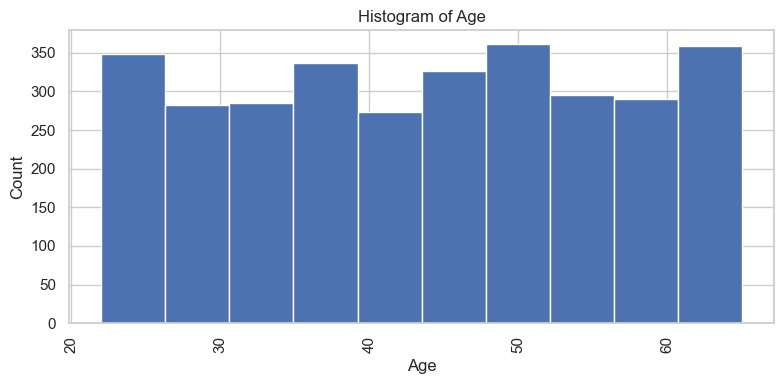

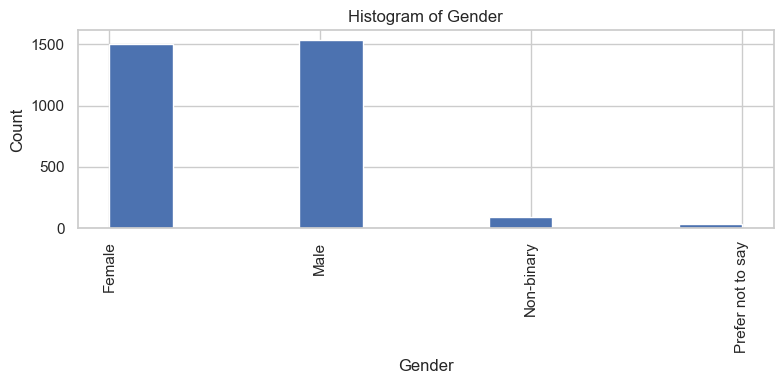

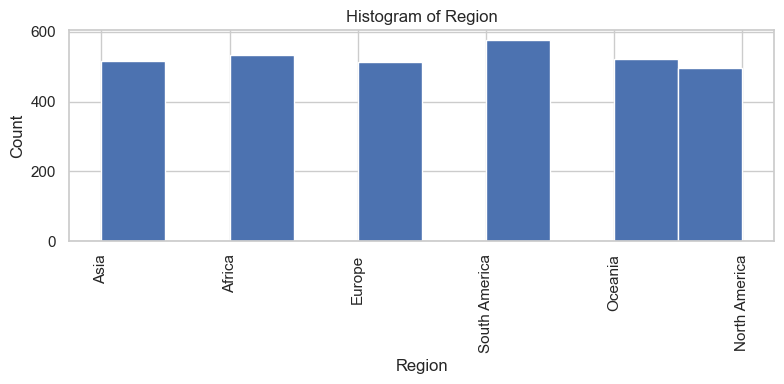

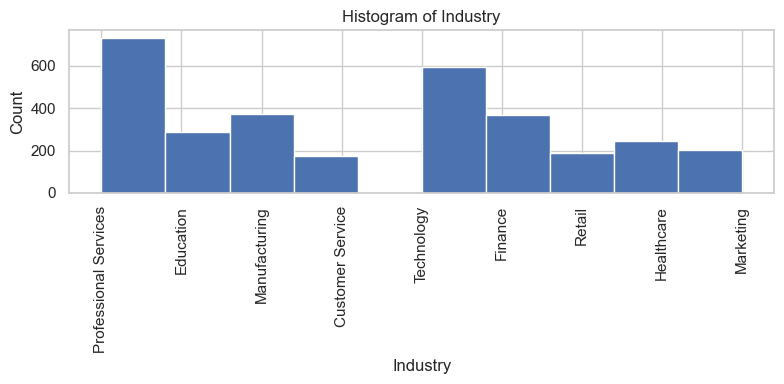

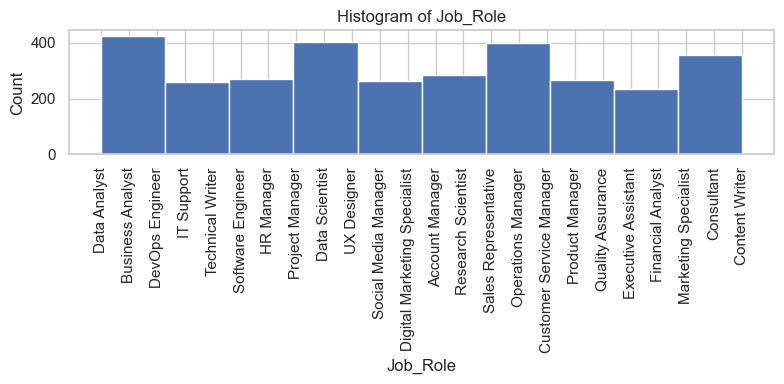

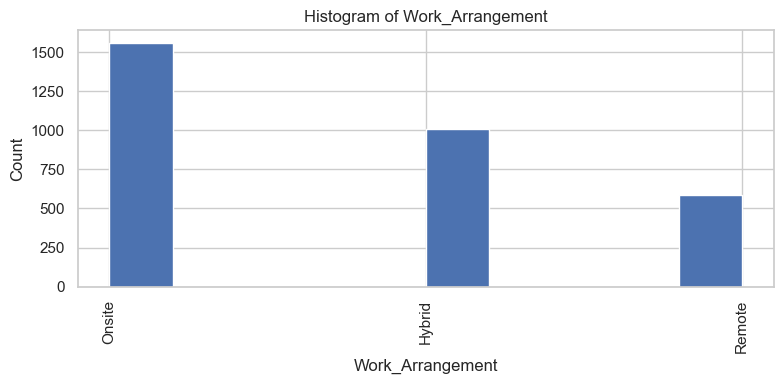

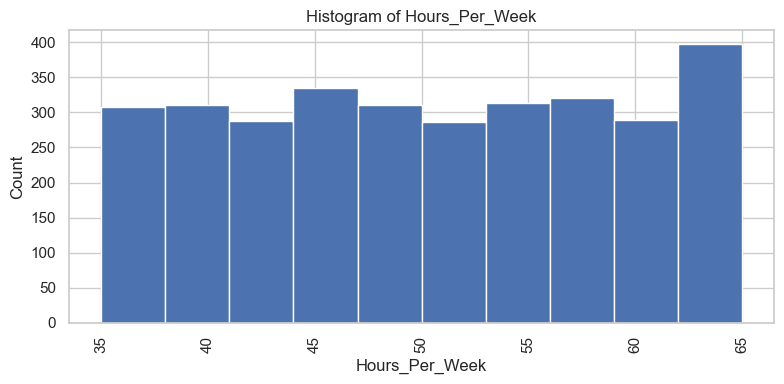

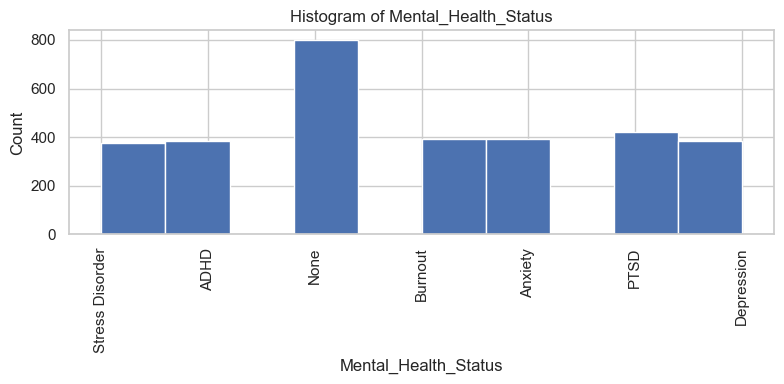

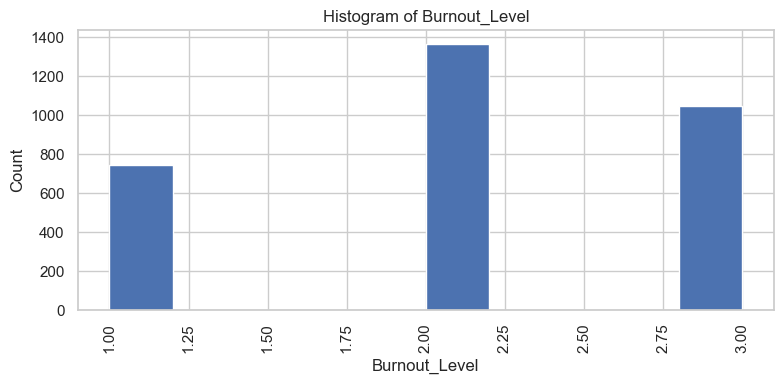

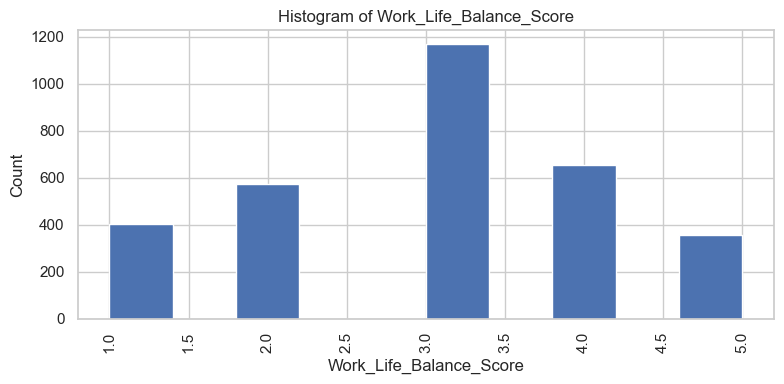

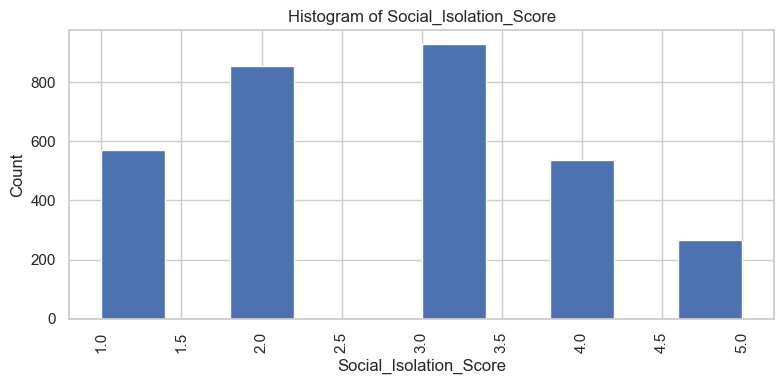

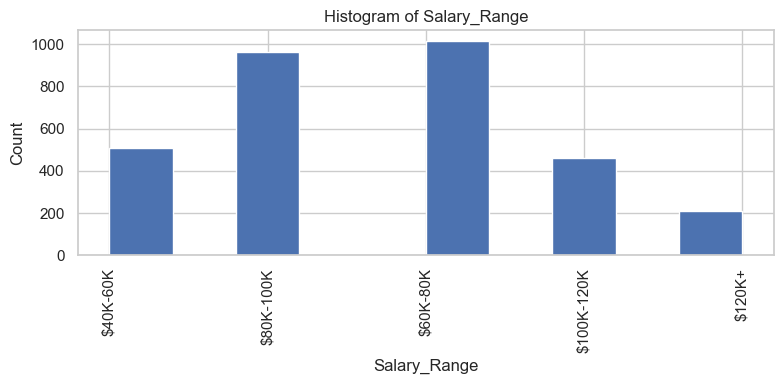

In [49]:
plot_histogram(df, ['Age', 'Gender', 'Region', 'Industry', 'Job_Role', 'Work_Arrangement', 'Hours_Per_Week', 'Mental_Health_Status', 'Burnout_Level', 'Work_Life_Balance_Score', 
                    'Social_Isolation_Score', 'Salary_Range'])

## Model Development

---- 

#### Decision Tree

In [50]:
df_encoded.head(5)

,Survey_Date,Age,Hours_Per_Week,Burnout_Level,Work_Life_Balance_Score,Social_Isolation_Score,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Africa,Region_Asia,Region_Europe,Region_North America,Region_Oceania,Region_South America,Industry_Customer Service,Industry_Education,Industry_Finance,Industry_Healthcare,Industry_Manufacturing,Industry_Marketing,Industry_Professional Services,Industry_Retail,Industry_Technology,Job_Role_Account Manager,Job_Role_Business Analyst,Job_Role_Consultant,Job_Role_Content Writer,Job_Role_Customer Service Manager,Job_Role_Data Analyst,Job_Role_Data Scientist,Job_Role_DevOps Engineer,Job_Role_Digital Marketing Specialist,Job_Role_Executive Assistant,Job_Role_Financial Analyst,Job_Role_HR Manager,Job_Role_IT Support,Job_Role_Marketing Specialist,Job_Role_Operations Manager,Job_Role_Product Manager,Job_Role_Project Manager,Job_Role_Quality Assurance,Job_Role_Research Scientist,Job_Role_Sales Representative,Job_Role_Social Media Manager,Job_Role_Software Engineer,Job_Role_Technical Writer,Job_Role_UX Designer,Work_Arrangement_Hybrid,Work_Arrangement_Onsite,Work_Arrangement_Remote,Mental_Health_Status_ADHD,Mental_Health_Status_Anxiety,Mental_Health_Status_Burnout,Mental_Health_Status_Depression,Mental_Health_Status_None,Mental_Health_Status_PTSD,Mental_Health_Status_Stress Disorder,Salary_Range_$100K-120K,Salary_Range_$120K+,Salary_Range_$40K-60K,Salary_Range_$60K-80K,Salary_Range_$80K-100K
0,2025-06-01,27,64,3,3,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,2025-06-01,37,37,3,4,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2025-06-01,32,36,3,3,2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2025-06-01,40,63,2,1,2,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,2025-06-01,30,65,2,5,4,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [51]:
# Initalize New Dataframe for Decision Tree
X = df_encoded.drop(columns = [
    'Survey_Date',
    'Work_Life_Balance_Score',
    'Social_Isolation_Score'
])

y1 = df['Work_Life_Balance_Score']
y2 = df['Social_Isolation_Score']

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size= 0.3, random_state = 123)
_      , _    , y2_train, y2_test = train_test_split(X, y2, test_size = 0.3, random_state = 123)

X_train.items()

def shape_prnt(**vars):
    """
    Print the .shape of each variable passed as a keyword argument.
    Usage:
      shape_prnt(X_train=X_train, X_test=X_test, y1_train=y1_train)
    """
    for name, arr in vars.items():
        if hasattr(arr, 'shape'):
            print(f"Shape of {name}: {arr.shape}")
        else:
            print(f"{name!r} has no .shape attribute")

shape_prnt(
    X_train=X_train,
    X_test=X_test,
    y1_train=y1_train,
    y1_test=y1_test,
    y2_train=y2_train,
    y2_test=y2_test
)


Shape of X_train: (2209, 61)
Shape of X_test: (948, 61)
Shape of y1_train: (2209,)
Shape of y1_test: (948,)
Shape of y2_train: (2209,)
Shape of y2_test: (948,)


### Start Model Development

#### Model 1: Regular Decision Tree Method

In [52]:
# clf_wlb = DecisionTreeClassifier(
#     max_depth=15,
#     min_samples_split=30,
#     min_samples_leaf=10,
#     random_state=42
# )

# clf_wlb.fit(X_train, y1_train)

# plt.figure(figsize=(150,30))

# tree.plot_tree(
#     clf_wlb, 
#     filled = True, 
#     rounded = True, 
#     feature_names= X.columns,
#     class_names = [str(c) for c in clf_wlb.classes_], 
#     fontsize=10
# )

# plt.show()

#### Model 2: GridSearch Method

In [53]:
## Grid Search Method 
param_grid = {
    'criterion':            ['gini', 'entropy'],
    'max_depth':            [3,5,6,7,15,20], 
    'min_samples_split':    [10,15,20], 
    'min_samples_leaf':     [3,5,10], 
    'max_leaf_nodes':       [None, 10, 20, 50]       
}

base_wlb_clf = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42
    )

wlb_grid = GridSearchCV(
    estimator = base_wlb_clf, 
    param_grid=param_grid,
    cv = 5,             # 5 fold cross validation
    scoring = 'accuracy', 
    n_jobs=-1 # use all cores 
)

# fit
wlb_grid.fit(X_train, y1_train)

print(f"Best Params: {wlb_grid.best_params_}")
print(f"Best CV Score: {wlb_grid.best_score_}")

# Evaluate the best estimator on the hold-out test set:
best_wlb_clf = wlb_grid.best_estimator_
print("Test accuracy:",
      best_wlb_clf.score(X_test, y1_test))


Best Params: {'criterion': 'gini', 'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV Score: 0.22045330952893977
Test accuracy: 0.1962025316455696


=== Training classification report ===
              precision    recall  f1-score   support

           1       0.48      0.72      0.58       279
           2       0.52      0.63      0.57       403
           3       0.77      0.34      0.48       827
           4       0.54      0.52      0.53       451
           5       0.40      0.79      0.53       249

    accuracy                           0.53      2209
   macro avg       0.54      0.60      0.53      2209
weighted avg       0.60      0.53      0.52      2209

=== Training confusion Matrix ===


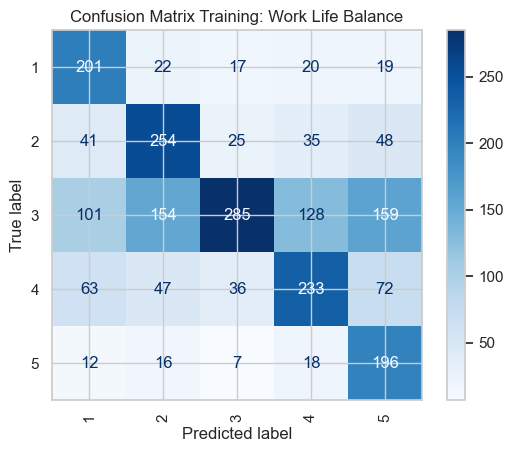

In [54]:
# Training Stats 
train_preds_wlb = best_wlb_clf.predict(X_train)

print("=== Training classification report ===")
print(classification_report(y1_train, train_preds_wlb))

print("=== Training confusion Matrix ===")
train_cm_wlb = confusion_matrix(y1_train, train_preds_wlb, labels = [1,2,3,4,5])
train_wlb_cm_display = ConfusionMatrixDisplay(
    train_cm_wlb, 
    display_labels=[1,2,3,4,5]
)

train_wlb_cm_display.plot(cmap = 'Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix Training: Work Life Balance')
plt.show()

classification report for work life balance 
               precision    recall  f1-score   support

           1       0.12      0.18      0.14       125
           2       0.24      0.27      0.25       169
           3       0.36      0.16      0.22       342
           4       0.20      0.19      0.20       204
           5       0.11      0.24      0.15       108

    accuracy                           0.20       948
   macro avg       0.21      0.21      0.19       948
weighted avg       0.24      0.20      0.20       948



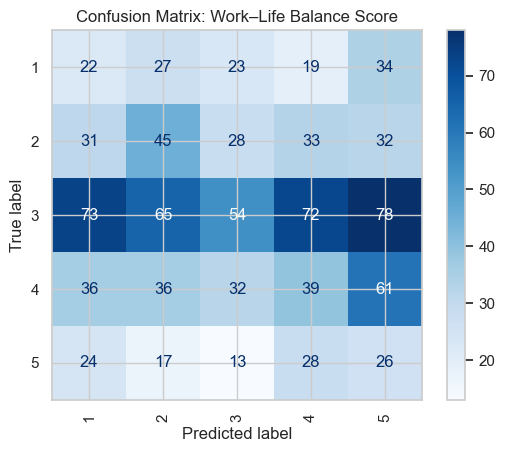

In [55]:
# Test Stats
preds_wlb = best_wlb_clf.predict(X_test)

print(f"classification report for work life balance \n {classification_report(y1_test, preds_wlb)}")

cm = confusion_matrix(y1_test, preds_wlb, labels=[1,2,3,4,5])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,2,3,4,5])

disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix: Work–Life Balance Score')
plt.show()

In [56]:
importances = pd.Series(
    best_wlb_clf.feature_importances_, 
    index=X_train.columns
).sort_values(ascending=False)

print(importances.head(20))    # top 20
print(importances.tail(10))    # lowest 10

Age                                0.220950
Hours_Per_Week                     0.202691
Burnout_Level                      0.053758
Work_Arrangement_Onsite            0.032665
Mental_Health_Status_ADHD          0.027623
Gender_Male                        0.025849
Industry_Finance                   0.022968
Salary_Range_$80K-100K             0.021900
Industry_Professional Services     0.021515
Salary_Range_$60K-80K              0.020991
Mental_Health_Status_Anxiety       0.020661
Mental_Health_Status_Depression    0.018646
Gender_Female                      0.016472
Work_Arrangement_Remote            0.016407
Mental_Health_Status_PTSD          0.016355
Mental_Health_Status_None          0.013300
Mental_Health_Status_Burnout       0.013094
Region_Asia                        0.012906
Work_Arrangement_Hybrid            0.012714
Industry_Manufacturing             0.011409
dtype: float64
Job_Role_Quality Assurance      0.002764
Job_Role_Technical Writer       0.000000
Job_Role_Executive Assi

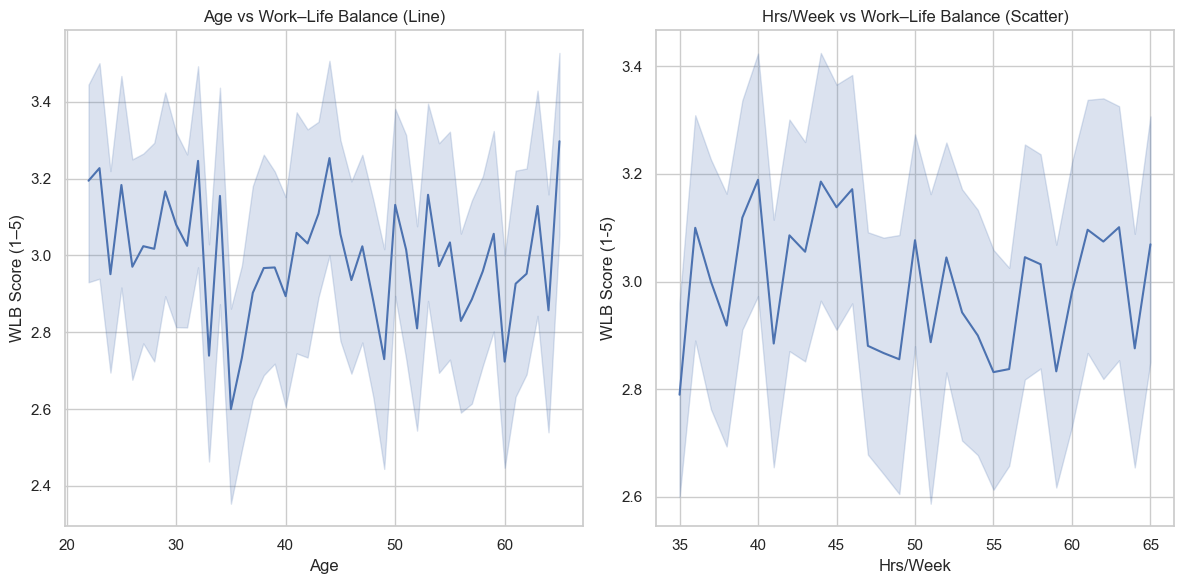

In [57]:
# Check Age Against important features
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,6))

sns.lineplot(
    x='Age',
    y='Work_Life_Balance_Score',
    data=df,
    ax=axes[0]
)

axes[0].set_title("Age vs Work–Life Balance (Line)")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("WLB Score (1–5)")

# — Right
sns.lineplot(
    x='Hours_Per_Week',
    y='Work_Life_Balance_Score',
    data=df,
    ax=axes[1]
)
axes[1].set_title("Hrs/Week vs Work–Life Balance (Scatter)")
axes[1].set_xlabel("Hrs/Week")
axes[1].set_ylabel("WLB Score (1-5)")

plt.tight_layout()
plt.show()

plt.show()

#### Model 3: Try some Random Forest

In [ ]:
# quickly balance classes 
smote = SMOTE() 

X_wlb_train_resampled, y1_train_resampled = smote.fit_resample(X_train, y1_train)

print(f"Resampled Shaped X Train: {X_wlb_train_resampled.shape}")
print(f"Resampled WLB target shape: {y1_train_resampled.shape}")
print("\n === New Values Counts ===")
print(y1_train_resampled.value_counts())

Resampled Shaped X Train: (4135, 61)
Resampled WLB target shape: (4135,)

 === New Values Counts ===
Work_Life_Balance_Score
3    827
4    827
5    827
2    827
1    827
Name: count, dtype: int64


In [59]:
from sklearn.ensemble import RandomForestClassifier

rf_grid = RandomForestClassifier(random_state=42)

# Set up GridSearch 
rf_parameter_grid = {
    'max_depth': [15, 20, 30], 
    'n_estimators': [100,200,220,240],
    'max_features': [12, 15, 20], # total features 61
    'min_samples_leaf': [3,6]
}

rf_grid = GridSearchCV(rf_grid, rf_parameter_grid, cv = 5, scoring = 'accuracy', verbose = 3)
model_grid = rf_grid.fit(X_wlb_train_resampled, y1_train_resampled)

print(f'Best hyperparamters: {str(model_grid.best_params_)}')
print(f'Best Score is: {str(model_grid.best_score_)}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=100;, score=0.245 total time=   0.2s
[CV 2/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=100;, score=0.365 total time=   0.1s
[CV 3/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=100;, score=0.487 total time=   0.1s
[CV 4/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=100;, score=0.539 total time=   0.2s
[CV 5/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=100;, score=0.505 total time=   0.2s
[CV 1/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=200;, score=0.238 total time=   0.3s
[CV 2/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=200;, score=0.360 total time=   0.3s
[CV 3/5] END max_depth=15, max_features=12, min_samples_leaf=3, n_estimators=200;, score=0.489 total time=   0.3s
[CV 4/5] END max_depth=15,

In [60]:
results = pd.DataFrame(rf_grid.cv_results_)

results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.151234,0.012954,0.007010,0.000396,15,12,3,100,"{'max_depth': 15, 'max_features': 12, 'min_sam...",0.245466,0.365175,0.487304,0.539299,0.505441,0.428537,0.108780,39
1,0.277776,0.013627,0.012525,0.000439,15,12,3,200,"{'max_depth': 15, 'max_features': 12, 'min_sam...",0.238210,0.360339,0.488513,0.540508,0.507860,0.427086,0.112509,40
2,0.312240,0.025987,0.014321,0.000608,15,12,3,220,"{'max_depth': 15, 'max_features': 12, 'min_sam...",0.235792,0.361548,0.494559,0.540508,0.501814,0.426844,0.113040,44
3,0.380083,0.016014,0.015659,0.000899,15,12,3,240,"{'max_depth': 15, 'max_features': 12, 'min_sam...",0.233374,0.363966,0.493349,0.539299,0.505441,0.427086,0.113693,40
4,0.129274,0.008129,0.006407,0.000125,15,12,6,100,"{'max_depth': 15, 'max_features': 12, 'min_sam...",0.226119,0.345828,0.469166,0.501814,0.466747,0.401935,0.102719,72


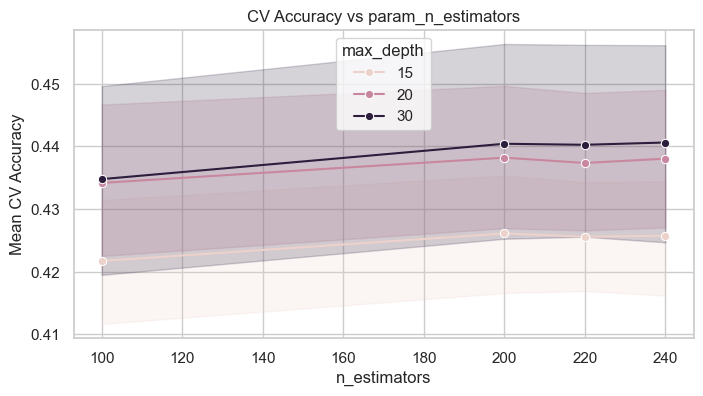

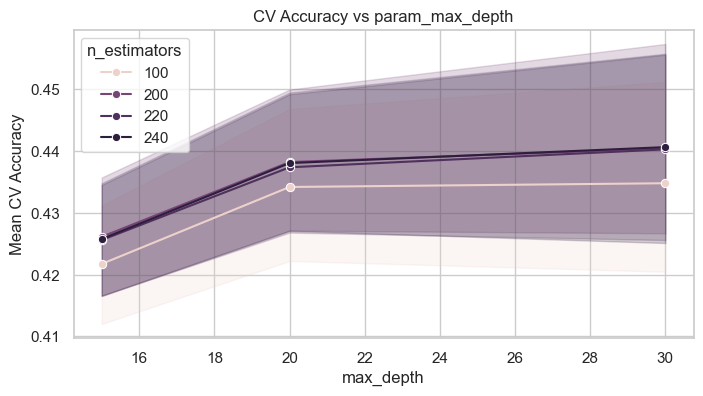

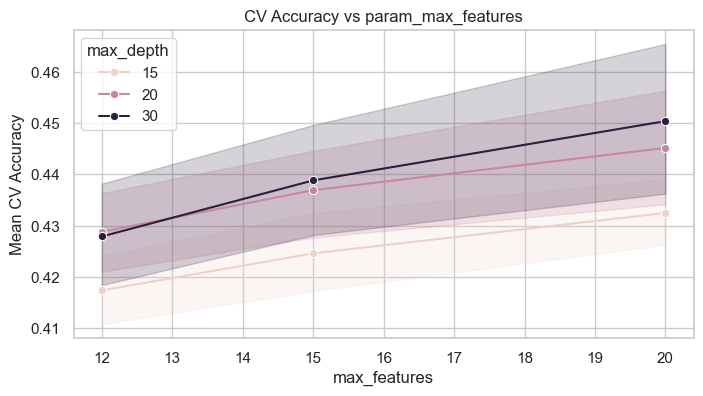

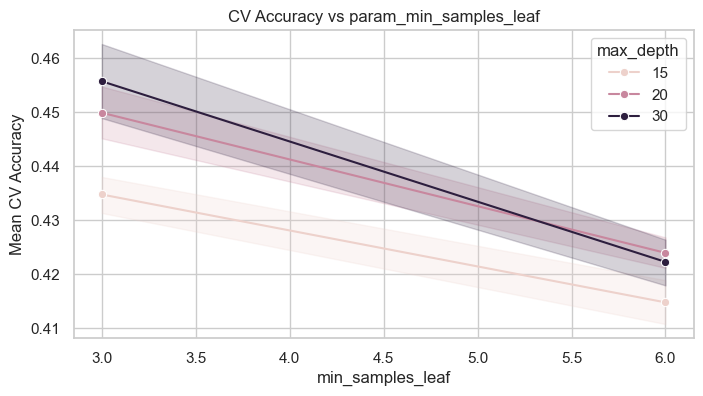

In [61]:
param_cols = [
    'param_n_estimators', 
    'param_max_depth',
    'param_max_features', 
    'param_min_samples_leaf'
]

sns.set_theme(style= 'whitegrid')

for param in param_cols: 
    plt.figure(figsize = (8,4))
    sns.lineplot(
        data = results, 
        x = param, 
        y = 'mean_test_score', 
        hue = 'param_max_depth' if param!='param_max_depth' else 'param_n_estimators',
        marker = 'o'
    )
    plt.title(f'CV Accuracy vs {param}')
    plt.xlabel(param.replace('param_', ''))
    plt.ylabel('Mean CV Accuracy')
    plt.legend(title=('max_depth' if param!='param_max_depth' else 'n_estimators'))
    plt.tight_layout
    plt.show()

#### Random Forest Test Results

In [66]:
# assign best fitting model
best_rf_wbl_model = model_grid.best_estimator_

y_rf_test_predictions = best_rf_wbl_model.predict(X_test)

print(f"Accuracy: {accuracy_score(y1_test, y_rf_test_predictions):.3f}")
print("\nClassification Report:\n", classification_report(y1_test, y_rf_test_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y1_test, y_rf_test_predictions))

Accuracy: 0.309

Classification Report:
               precision    recall  f1-score   support

           1       0.15      0.05      0.07       125
           2       0.18      0.10      0.13       169
           3       0.36      0.70      0.48       342
           4       0.23      0.13      0.17       204
           5       0.07      0.02      0.03       108

    accuracy                           0.31       948
   macro avg       0.20      0.20      0.18       948
weighted avg       0.24      0.31      0.24       948


Confusion Matrix:
 [[  6  15  90   9   5]
 [  9  17 117  19   7]
 [ 16  33 241  46   6]
 [  7  20 141  27   9]
 [  3   9  77  17   2]]


## Neural Network Method 

In [91]:
import torch
import torch.nn as nn

The softmax function to squeeze the logits across 
$$
(z_1, z_2, z_3)
$$ 

to 0 to 1 is defined as:

$$
\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^3 e^{z_j}}
$$

For multiclass classification, you can use categorical cross entropy as the loss metric. 

The cross‐entropy between a true distribution \(p\) and a predicted distribution \(q\) is:

$$
H(p, q) \;=\; -\sum_{x} p(x)\,\log q(x)
$$

This means that, given the real probability vector \(p(x)\) and the predicted probability vector \(q(x)\), the loss is the negative log-likelihood of the true class under \(q\). Since \(p\) is one-hot, only the term for the true class contributes: when \(q(x)\to 1\) the loss goes to 0, and as \(q(x)\to 0\) the loss \(-\log q(x)\) goes to infinity.

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3157 entries, 0 to 3156
Data columns (total 64 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Survey_Date                            3157 non-null   datetime64[ns]
 1   Age                                    3157 non-null   int64         
 2   Hours_Per_Week                         3157 non-null   int64         
 3   Burnout_Level                          3157 non-null   int64         
 4   Work_Life_Balance_Score                3157 non-null   int64         
 5   Social_Isolation_Score                 3157 non-null   int64         
 6   Gender_Female                          3157 non-null   int64         
 7   Gender_Male                            3157 non-null   int64         
 8   Gender_Non-binary                      3157 non-null   int64         
 9   Gender_Prefer not to say               3157 non-null   int64   

In [70]:
df_encoded.head(3)

,Survey_Date,Age,Hours_Per_Week,Burnout_Level,Work_Life_Balance_Score,Social_Isolation_Score,Gender_Female,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Region_Africa,Region_Asia,Region_Europe,Region_North America,Region_Oceania,Region_South America,Industry_Customer Service,Industry_Education,Industry_Finance,Industry_Healthcare,Industry_Manufacturing,Industry_Marketing,Industry_Professional Services,Industry_Retail,Industry_Technology,Job_Role_Account Manager,Job_Role_Business Analyst,Job_Role_Consultant,Job_Role_Content Writer,Job_Role_Customer Service Manager,Job_Role_Data Analyst,Job_Role_Data Scientist,Job_Role_DevOps Engineer,Job_Role_Digital Marketing Specialist,Job_Role_Executive Assistant,Job_Role_Financial Analyst,Job_Role_HR Manager,Job_Role_IT Support,Job_Role_Marketing Specialist,Job_Role_Operations Manager,Job_Role_Product Manager,Job_Role_Project Manager,Job_Role_Quality Assurance,Job_Role_Research Scientist,Job_Role_Sales Representative,Job_Role_Social Media Manager,Job_Role_Software Engineer,Job_Role_Technical Writer,Job_Role_UX Designer,Work_Arrangement_Hybrid,Work_Arrangement_Onsite,Work_Arrangement_Remote,Mental_Health_Status_ADHD,Mental_Health_Status_Anxiety,Mental_Health_Status_Burnout,Mental_Health_Status_Depression,Mental_Health_Status_None,Mental_Health_Status_PTSD,Mental_Health_Status_Stress Disorder,Salary_Range_$100K-120K,Salary_Range_$120K+,Salary_Range_$40K-60K,Salary_Range_$60K-80K,Salary_Range_$80K-100K
0,2025-06-01,27,64,3,3,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
1,2025-06-01,37,37,3,4,2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,2025-06-01,32,36,3,3,2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [80]:
X.values

array([[27, 64,  3, ...,  1,  0,  0],
       [37, 37,  3, ...,  0,  0,  1],
       [32, 36,  3, ...,  0,  0,  1],
       ...,
       [45, 59,  2, ...,  1,  0,  0],
       [38, 52,  2, ...,  0,  0,  1],
       [54, 39,  2, ...,  0,  0,  0]])

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

le1     = LabelEncoder()
y1_int  = le1.fit_transform(y1.values)
num_classes1 = len(le1.classes_)

le2     = LabelEncoder()
y2_int  = le2.fit_transform(y2.values)
num_classes2 = len(le2.classes_)

X_train_df, X_test_df, \
y1_train, y1_test, \
y2_train, y2_test = train_test_split(
    X,           # pandas DataFrame
    y1_int,      # zero‐based labels
    y2_int,
    test_size=0.2,
    random_state=42,
    stratify=y1_int
)

numeric_cols = ['Age', 'Hours_Per_Week', 'Burnout_Level']
ct = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols)
], remainder='passthrough')

X_train_scaled = ct.fit_transform(X_train_df)
X_test_scaled  = ct.transform(X_test_df)

sm1 = SMOTE(random_state=42)
X1_res, y1_res = sm1.fit_resample(X_train_scaled, y1_train)

sm2 = SMOTE(random_state=42)
X2_res, y2_res = sm2.fit_resample(X_train_scaled, y2_train)

print("After resampling y1:", X1_res.shape, y1_res.shape)
print("After resampling y2:", X2_res.shape, y2_res.shape)

After resampling y1: (4675, 61) (4675,)
After resampling y2: (3715, 61) (3715,)


In [ ]:
class MulticlassWLB(nn.Module): 
    def __init__(self, input_dim, hidden_dims, num_classes, p_dropout = 0.5): 
        super().__init__()

        layers = []
        # initialize first dimensions
        prev_dim = input_dim

        for h in hidden_dims: 
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU(inplace = True))
            layers.append(nn.Dropout(p_dropout))
            prev_dim = h

        layers.append(nn.Linear(prev_dim, num_classes)) # output layer

        self.net = nn.Sequential(*layers)

    def forward(self, x): 
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MulticlassWLB(
    input_dim=X1_res.shape[1],
    hidden_dims=[128, 64],
    num_classes=num_classes1,
    p_dropout=0.3
).to(device)


X_train_t = torch.tensor(X1_res, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y1_res, dtype=torch.long).to(device)
train_ds  = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)


X_val_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_val_t = torch.tensor(y1_test,     dtype=torch.long).to(device)
val_ds    = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_ds, batch_size=64)


loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


best_val_loss = float('inf')
best_epoch    = 0
best_state    = None

for epoch in range(1, 101):
    # — train pass —
    model.train()
    total_train = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss   = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item() * xb.size(0)
    avg_train_loss = total_train / len(train_loader.dataset)

    # — val pass —
    model.eval()
    total_val = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            logits = model(xb)
            total_val += loss_fn(logits, yb).item() * xb.size(0)
    avg_val_loss = total_val / len(val_loader.dataset)

    print(f"Epoch {epoch:03d} | Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch    = epoch
        best_state    = model.state_dict()

print(f"\nBest epoch = {best_epoch}, Val loss = {best_val_loss:.4f}")
model.load_state_dict(best_state)

Epoch 001 | Train: 1.6057 | Val: 1.6158
Epoch 002 | Train: 1.5746 | Val: 1.6151
Epoch 003 | Train: 1.5223 | Val: 1.6412
Epoch 004 | Train: 1.4626 | Val: 1.6381
Epoch 005 | Train: 1.3931 | Val: 1.6769
Epoch 006 | Train: 1.3327 | Val: 1.7200
Epoch 007 | Train: 1.2830 | Val: 1.7355
Epoch 008 | Train: 1.2301 | Val: 1.7435
Epoch 009 | Train: 1.1825 | Val: 1.8036
Epoch 010 | Train: 1.1415 | Val: 1.8024
Epoch 011 | Train: 1.0974 | Val: 1.8286
Epoch 012 | Train: 1.0701 | Val: 1.8690
Epoch 013 | Train: 1.0373 | Val: 1.8617
Epoch 014 | Train: 1.0173 | Val: 1.9051
Epoch 015 | Train: 0.9959 | Val: 1.9282
Epoch 016 | Train: 0.9733 | Val: 1.9411
Epoch 017 | Train: 0.9444 | Val: 1.9931
Epoch 018 | Train: 0.9116 | Val: 2.0472
Epoch 019 | Train: 0.9110 | Val: 2.0362
Epoch 020 | Train: 0.8942 | Val: 2.0392
Epoch 021 | Train: 0.8589 | Val: 2.0614
Epoch 022 | Train: 0.8665 | Val: 2.0552
Epoch 023 | Train: 0.8233 | Val: 2.1274
Epoch 024 | Train: 0.8240 | Val: 2.0936
Epoch 025 | Train: 0.8148 | Val: 2.1384


<All keys matched successfully>

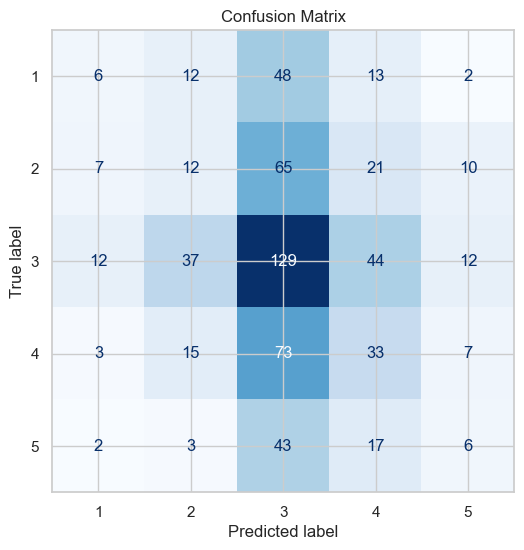

Accuracy: 0.294


In [125]:
model.eval()

X_new_df = X_test_df 

X_new_scaled = ct.transform(X_new_df) 

X_new_t = torch.tensor(X_new_scaled, dtype = torch.float32).to(device)

with torch.no_grad(): 
    logits = model(X_new_t)

pred_indices = torch.argmax(logits, dim = 1) 
pred_indices = pred_indices.cpu().numpy()

y_true = y1_test            
y_pred = pred_indices       

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le1.classes_ 
)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)  # default colormap; no seaborn
ax.set_title("Confusion Matrix")
plt.show()

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.3f}")
